In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import time

In [2]:
def load_data_airfoil():
    data = np.genfromtxt('/home/data/airfoil_self_noise.dat',delimiter='\t')
    data = (data-data.mean(axis=0))/data.std(axis=0)
    features = torch.tensor(data[:1500,:-1],dtype=torch.float32)
    labels = torch.tensor(data[:1500,-1],dtype=torch.float32)
    return features,labels
features,labels = load_data_airfoil()
print(features.shape,labels.shape)

torch.Size([1500, 5]) torch.Size([1500])


In [26]:
def init_momentum_states():
    v_w = torch.zeros((features.shape[1],1),dtype=torch.float32)
    v_b = torch.zeros(1,dtype=torch.float32)
    return (v_w,v_b)
states = init_momentum_states()

In [25]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

In [28]:
def train_ch7(optimizer_fn,optimizer_hyperparams,features,labels,batch_size=10,num_epochs=2):
    loss = nn.MSELoss()
    net = nn.Sequential(nn.Linear(features.shape[-1],1))
    optimizer = optimizer_fn(net.parameters(),**optimizer_hyperparams)
    def eval_loss():
        return loss(net(features).view(-1),labels).item()/2
    ls = [eval_loss()]
    data = torch.utils.data.TensorDataset(features,labels)
    data_iter = torch.utils.data.DataLoader(data,batch_size,shuffle=True)
    for epoch in range(num_epochs):
        start = time.time()
        for batch_i,(X,Y)in enumerate(data_iter):
            y_hat = net(X)
            l = loss(y_hat.view(-1),Y)/2
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i+1)*batch_size%100==0:
                ls.append(eval_loss())
    print('loss:%f,%f sec per epoch'%(ls[-1],time.time()-start))
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize']=(3,3)
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs:')
    plt.ylabel('loss:')

In [31]:
train_ch7(sgd_momentum,init_momentum_states(),{'momentum':0.5,'lr':0.02}, features, labels,10)

TypeError: sgd_momentum() argument after ** must be a mapping, not tuple

loss:0.245974,0.094130 sec per epoch


/tmp/ipykernel_51234/958348567.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


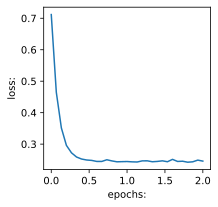

In [ ]:
# train_ch7(torch.optim.SGD,{'lr':0.05},features,labels)


In [ ]:
#     d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
#                    {'lr': lr, 'momentum': momentum}, data_iter,
#                    feature_dim, num_epochs)
# def train_ch11(trainer_fn, states, hyperparams, data_iter,
#                feature_dim, num_epochs=2):
#     """Defined in :numref:`sec_minibatches`"""
#     # 初始化模型
#     w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
#                      requires_grad=True)
#     b = torch.zeros((1), requires_grad=True)
#     net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
#     # 训练模型
#     animator = d2l.Animator(xlabel='epoch', ylabel='loss',
#                             xlim=[0, num_epochs], ylim=[0.22, 0.35])
#     n, timer = 0, d2l.Timer()
#     for _ in range(num_epochs):
#         for X, y in data_iter:
#             l = loss(net(X), y).mean()
#             l.backward()
#             trainer_fn([w, b], states, hyperparams)
#             n += X.shape[0]
#             if n % 200 == 0:
#                 timer.stop()
#                 animator.add(n/X.shape[0]/len(data_iter),
#                              (d2l.evaluate_loss(net, data_iter, loss),))
#                 timer.start()
#     print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
#     return timer.cumsum(), animator.Y[0]
# def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
#     """Defined in :numref:`sec_minibatches`"""
#     # 初始化模型
#     net = nn.Sequential(nn.Linear(5, 1))
#     def init_weights(m):
#         if type(m) == nn.Linear:
#             torch.nn.init.normal_(m.weight, std=0.01)
#     net.apply(init_weights)

#     optimizer = trainer_fn(net.parameters(), **hyperparams)
#     loss = nn.MSELoss(reduction='none')
#     animator = d2l.Animator(xlabel='epoch', ylabel='loss',
#                             xlim=[0, num_epochs], ylim=[0.22, 0.35])
#     n, timer = 0, d2l.Timer()
#     for _ in range(num_epochs):
#         for X, y in data_iter:
#             optimizer.zero_grad()
#             out = net(X)
#             y = y.reshape(out.shape)
#             l = loss(out, y)
#             l.mean().backward()
#             optimizer.step()
#             n += X.shape[0]
#             if n % 200 == 0:
#                 timer.stop()
#                 # MSELoss计算平方误差时不带系数1/2
#                 animator.add(n/X.shape[0]/len(data_iter),
#                              (d2l.evaluate_loss(net, data_iter, loss) / 2,))
#                 timer.start()
#     print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
# trainer = torch.optim.SGD
# d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)